# 04 - Evaluate Trained Classifiers on Full and Cropped Images

In [1]:
import os

os.chdir('..')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch

from src.core import models, training, data, metrics, loss_functions
from src.utils import nb_setup, visualization as viz

BBOX_DATA_DIR = '03_informed_augmentation/data_fungi/'
DATA_DIR = 'data/danish_fungi_dataset/'
TRAIN_SET_DIR = 'train_resized'

MODEL_ARCH = 'efficientnet_b0'
# MODEL_NAME_FULL = 'baselines_mini/df2020_efficientnet_b0_ce_11-04-2021_19-52-55'  # trained on full images
MODEL_NAME_FULL = 'df2020_efficientnet_b0_ce_11-23-2021_13-25-42'  # trained on full images
MODEL_NAME_CROP = 'image_cropping_mini/df2020_efficientnet_b0_ce_11-04-2021_21-27-17'  # trained on crop images
MODEL_NAME_MIX = 'image_cropping_mini/df2020_efficientnet_b0_ce_11-19-2021_09-48-57'  # trained on full and crop images

SEED = 42

nb_setup.init()
nb_setup.set_random_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda


## Load the Data

In [3]:
train_df = pd.read_csv(DATA_DIR + 'DF20M-train_metadata_PROD.csv')
valid_df = pd.read_csv(DATA_DIR + 'DF20M-public_test_metadata_PROD.csv')

classes = np.unique(train_df['scientificName'])
no_classes = len(classes)
assert no_classes == len(np.unique(valid_df['scientificName']))
print(f'No classes: {no_classes}')
print(f'Train set length: {len(train_df):,d}')
print(f'Validation set length: {len(valid_df):,d}')

No classes: 182
Train set length: 32,753
Validation set length: 3,640


Mean bounding box area: 0.33907
Median bounding box area: 0.32087


<AxesSubplot:ylabel='Frequency'>

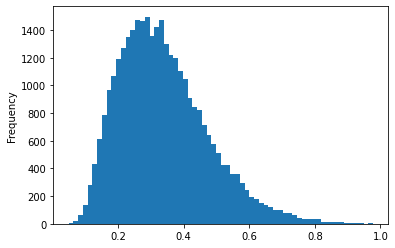

In [4]:
# include bbox annotations to the training set
bbox_df = pd.read_csv(BBOX_DATA_DIR + 'DFM_bbox_annotations.csv')
bbox_df = bbox_df.drop_duplicates('ImageUniqueID')
# assert len(bbox_df) >= len(train_df) + len(valid_df)
train_df = train_df.merge(bbox_df, 'left', on='ImageUniqueID', validate='one_to_one')
valid_df = valid_df.merge(bbox_df, 'left', on='ImageUniqueID', validate='one_to_one')

# create bbox column
for _df in [train_df, valid_df]:
    _df['bbox'] = _df[['xmin', 'ymin', 'xmax', 'ymax']].apply(lambda r: data.BBox(*r.values), axis=1)
    _df['bbox_area'] = _df['bbox'].apply(lambda bbox: bbox.area)

# get stats about bounding boxes
print('Mean bounding box area: {:.5f}'.format(train_df['bbox_area'].mean()))
print('Median bounding box area: {:.5f}'.format(train_df['bbox_area'].median()))
train_df['bbox_area'].plot(kind='hist', bins=64)

In [5]:
model_config = models.get_model(MODEL_ARCH, pretrained=False).pretrained_config
batch_size = 128

# create transforms
_, valid_tfms = data.get_transforms(
    size=model_config['input_size'], mean=model_config['image_mean'],
    std=model_config['image_std'])

## Create Predictions on Full and Cropped Images

In [6]:
def predict_cached(model, validloader, *,
                   path, pred_filename, targ_filename, force=False):
    import os

    cached_files = os.listdir(path)
    if not force and pred_filename in cached_files and targ_filename in cached_files:
        pred = np.load(path + pred_filename)
        targ = np.load(path + targ_filename)
    else:
        pred, targ, _ = training.predict(model, validloader)
        np.save(path + pred_filename, pred)
        np.save(path + targ_filename, targ)
    return pred, targ


# create model fine-tuned on full images
model_full = models.get_model(MODEL_ARCH, no_classes, pretrained=True)
training.load_model(model_full, MODEL_NAME_FULL, path=DATA_DIR + 'models')
assert np.all([param.requires_grad for param in model_full.parameters()])

# create model fine-tuned on cropped images
model_crop = models.get_model(MODEL_ARCH, no_classes, pretrained=True)
training.load_model(model_crop, MODEL_NAME_CROP, path=DATA_DIR + 'models')
assert np.all([param.requires_grad for param in model_crop.parameters()])

# create model fine-tuned on mix images
model_mix = models.get_model(MODEL_ARCH, no_classes, pretrained=True)
training.load_model(model_mix, MODEL_NAME_MIX, path=DATA_DIR + 'models')
assert np.all([param.requires_grad for param in model_mix.parameters()])

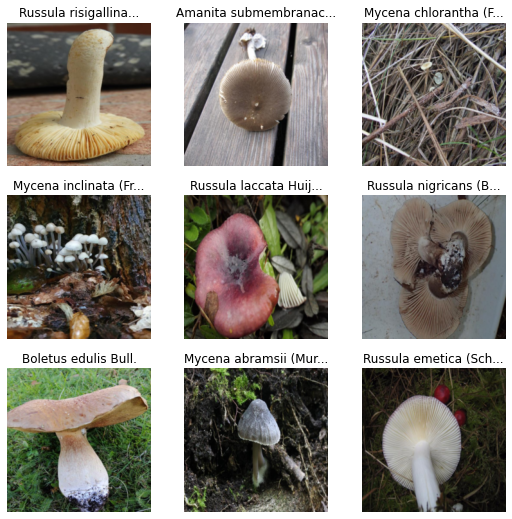

In [7]:
# create data loaders
validloader_full = data.get_dataloader(
    valid_df, img_path_col='image_path', label_col='scientificName',
    path=DATA_DIR + TRAIN_SET_DIR, transforms=valid_tfms, labels=classes,
    batch_size=batch_size, shuffle=False, num_workers=4)

validloader_full.dataset.show_items()

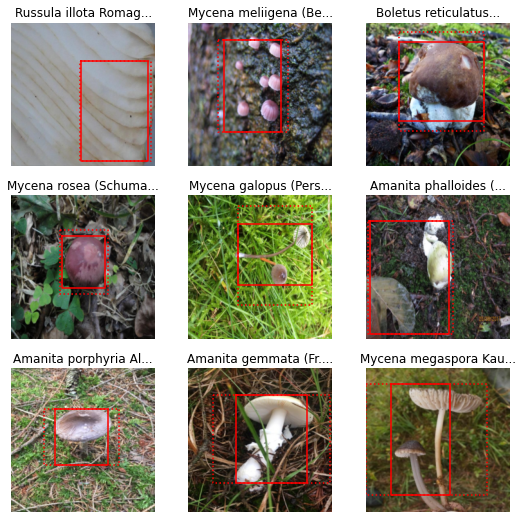

In [8]:
# create data loaders
validloader_crop = data.get_dataloader(
    valid_df, img_path_col='image_path', label_col='scientificName',
    bbox_col='bbox', labels=classes,
    path=DATA_DIR + TRAIN_SET_DIR, transforms=valid_tfms,
    batch_size=batch_size, shuffle=False, num_workers=4)

validloader_crop.dataset.show_items()

### Trained on Full | Predicted on Full

In [9]:
pred_val_full_full, targ_val_full_full = predict_cached(
    model_full, validloader_full, path=BBOX_DATA_DIR,
    pred_filename='pred_val_full_full.npy', targ_filename='targ_val_full_full.npy')

scores = training.classification_scores(pred_val_full_full, targ_val_full_full)
scores

{'accuracy': 0.6313186813186813,
 'top_3': 0.8123626373626374,
 'f1_score': 0.5276783363125843}

### Trained on Full | Predicted on Cropped

In [10]:
pred_val_full_crop, targ_val_full_crop = predict_cached(
    model_full, validloader_crop, path=BBOX_DATA_DIR,
    pred_filename='pred_val_full_crop.npy', targ_filename='targ_val_full_crop.npy')

scores = training.classification_scores(pred_val_full_crop, targ_val_full_crop)
scores

{'accuracy': 0.5903846153846154,
 'top_3': 0.7865384615384615,
 'f1_score': 0.487755128522515}

### Trained on Cropped | Predicted on Full

In [ ]:
pred_val_crop_full, targ_val_crop_full = predict_cached(
    model_crop, validloader_full, path=BBOX_DATA_DIR,
    pred_filename='pred_val_crop_full.npy', targ_filename='targ_val_crop_full.npy')

scores = training.classification_scores(pred_val_crop_full, targ_val_crop_full)
scores

{'accuracy': 0.585989010989011,
 'top_3': 0.7755494505494506,
 'f1_score': 0.45203209975634695}

### Trained on Cropped | Predicted on Cropped

In [ ]:
pred_val_crop_crop, targ_val_crop_crop = predict_cached(
    model_crop, validloader_crop, path=BBOX_DATA_DIR,
    pred_filename='pred_val_crop_crop.npy', targ_filename='targ_val_crop_crop.npy')

scores = training.classification_scores(pred_val_crop_crop, targ_val_crop_crop)
scores

{'accuracy': 0.6244505494505495,
 'top_3': 0.8021978021978022,
 'f1_score': 0.5115257995198733}

### Trained on Mix | Predicted on Full

In [14]:
pred_val_mix_full, targ_val_mix_full = predict_cached(
    model_mix, validloader_full, path=BBOX_DATA_DIR,
    pred_filename='pred_val_mix_full.npy', targ_filename='targ_val_mix_full.npy')

scores = training.classification_scores(pred_val_mix_full, targ_val_mix_full)
scores

{'accuracy': 0.6329670329670329,
 'top_3': 0.8222527472527472,
 'f1_score': 0.5033230601555078}

### Trained on Mix | Predicted on Cropped

In [15]:
pred_val_mix_crop, targ_val_mix_crop = predict_cached(
    model_mix, validloader_crop, path=BBOX_DATA_DIR,
    pred_filename='pred_val_mix_crop.npy', targ_filename='targ_val_mix_crop.npy')

scores = training.classification_scores(pred_val_mix_crop, targ_val_mix_crop)
scores

{'accuracy': 0.6450549450549451,
 'top_3': 0.8208791208791208,
 'f1_score': 0.5278305965330357}

## Evaluate Predictions of Cropped Images

In [15]:
from tqdm import tqdm

# create evaluation dataframe
eval_df = valid_df[['scientificName', 'bbox', 'bbox_area']].copy()
eval_df['bbox_area_bin'] = np.round(eval_df['bbox_area'], 1)
eval_df['targ'] = targ_val_crop_crop
eval_df['pred'] = pred_val_crop_crop.argmax(1)

/mnt/appl/software/SciPy-bundle/2020.11-fosscuda-2020b/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/mnt/appl/software/SciPy-bundle/2020.11-fosscuda-2020b/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


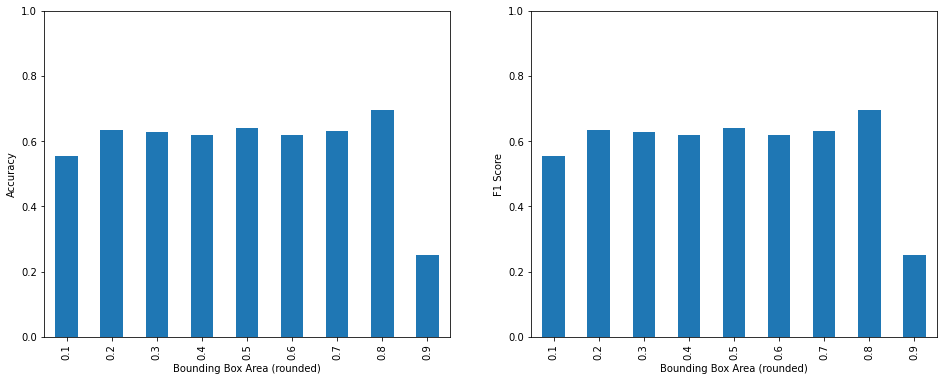

In [16]:
from sklearn.metrics import accuracy_score, f1_score

fig, (ax1, ax2) = viz.create_fig(ncols=2)

acc = eval_df.groupby('bbox_area_bin').apply(lambda g: accuracy_score(g['targ'], g['pred']))
acc.plot(kind='bar', ylim=[0, 1], ax=ax1)
ax1.set(ylabel='Accuracy', xlabel='Bounding Box Area (rounded)')

f1 = eval_df.groupby('bbox_area_bin').apply(lambda g: f1_score(g['targ'], g['pred'], average='macro'))
acc.plot(kind='bar', ylim=[0, 1], ax=ax2)
ax2.set(ylabel='F1 Score', xlabel='Bounding Box Area (rounded)')
plt.show()

## Compare Predictions of Full and Cropped Images

In [17]:
def softmax(x, axis=-1):
    e = np.exp(x - x.max())  # X.max() makes function exp more stable
    return e / e.sum(axis=axis, keepdims=True)


pred_val_full_full = softmax(pred_val_full_full)
pred_val_crop_crop = softmax(pred_val_crop_crop)

assert np.all(targ_val_full_full == targ_val_crop_crop)
targ = targ_val_full_full

# create evaluation dataframe
eval_df = pd.DataFrame()
eval_df['BBox Area'] = valid_df['bbox_area']
eval_df['Target'] = targ
eval_df['Predicted (original)'] = pred_val_full_full.argmax(1)
eval_df['Prob (original)'] = pred_val_full_full.max(1)
eval_df['Predicted (cropped)'] = pred_val_crop_crop.argmax(1)
eval_df['Prob (cropped)'] = pred_val_crop_crop.max(1)

eval_df

,BBox Area,Target,Predicted (original),Prob (original),Predicted (cropped),Prob (cropped)
0,0.296396,147,147,0.999599,147,0.877506
1,0.620336,78,97,0.661795,78,0.558809
2,0.268714,94,94,0.999024,94,0.997839
3,0.693081,12,12,0.942604,12,0.987668
4,0.461695,115,115,0.666378,115,0.550988
...,...,...,...,...,...,...
3635,0.216199,40,40,0.965224,40,0.953597
3636,0.303133,87,87,0.776424,87,0.938794
3637,0.323342,50,50,0.502972,50,0.605056
3638,0.200256,27,27,0.977477,27,0.973473


### Prediction Statistics

In [18]:
acc_full = np.sum(eval_df['Target'] == eval_df['Predicted (original)']) / len(eval_df)
acc_crop = np.sum(eval_df['Target'] == eval_df['Predicted (cropped)']) / len(eval_df)

pd.Series({
    'Accuracy (original)': acc_full,
    'Accuracy (cropped)': acc_crop})

Accuracy (original)    0.631319
Accuracy (cropped)     0.624451
dtype: float64

In [19]:
improved_acc = np.sum((eval_df['Target'] != eval_df['Predicted (original)']) &
                      (eval_df['Target'] == eval_df['Predicted (cropped)'])) / len(eval_df)
worse_acc = np.sum((eval_df['Target'] == eval_df['Predicted (original)']) &
                   (eval_df['Target'] != eval_df['Predicted (cropped)'])) / len(eval_df)

assert np.allclose(acc_full + improved_acc - worse_acc, acc_crop)
pd.Series({
    'Fraction of improved cases by cropping': improved_acc,
    'Fraction of worsened cases by cropping': worse_acc,
    'Difference': improved_acc - worse_acc})

Fraction of improved cases by cropping    0.100549
Fraction of worsened cases by cropping    0.107418
Difference                               -0.006868
dtype: float64

In [20]:
results_equal = np.sum(eval_df['Predicted (original)'] == eval_df['Predicted (cropped)']) / len(eval_df)
both_correct = np.sum((eval_df['Target'] == eval_df['Predicted (original)']) &
                      (eval_df['Target'] == eval_df['Predicted (cropped)'])) / len(eval_df)
both_wrong = np.sum((eval_df['Target'] != eval_df['Predicted (original)']) &
                    (eval_df['Target'] != eval_df['Predicted (cropped)'])) / len(eval_df)

pd.Series({
    'Original and Cropped are same': results_equal,
    'Both Original and Cropped are correct': both_correct,
    'Both Original and Cropped are wrong': both_wrong,
    'Original or Cropped is correct': 1 - both_wrong})

Original and Cropped are same            0.632418
Both Original and Cropped are correct    0.523901
Both Original and Cropped are wrong      0.268132
Original or Cropped is correct           0.731868
dtype: float64

In [21]:
# combine predictions based on the best probability
combined_pred = eval_df['Predicted (original)'].copy()
cond = eval_df['Prob (cropped)'] > eval_df['Prob (original)']
combined_pred[cond] = eval_df.loc[cond, 'Predicted (cropped)']
acc_comb = np.sum(eval_df['Target'] == combined_pred) / len(eval_df)

combined_pred_2 = np.argmax((pred_val_crop_crop + pred_val_full_full) / 2, 1)
acc_comb_2 = np.sum(eval_df['Target'] == combined_pred_2) / len(eval_df)

pd.Series({
    'Accuracy (original)': acc_full,
    'Accuracy (cropped)': acc_crop,
    'Accuracy (combined)': acc_comb,
    'Accuracy (combined - averaging probs)': acc_comb_2})

Accuracy (original)                      0.631319
Accuracy (cropped)                       0.624451
Accuracy (combined)                      0.659341
Accuracy (combined - averaging probs)    0.661264
dtype: float64